## 序列模型

### 建模过程

在时间$t$观察到一个数据$x_{t}$, 那么如果有$T$个时间的话，我们可以得到$T$个不独立的随机变量：$\left(x_{1}, \ldots x_{T}\right) \sim p(\mathbf{x})$。机器学习就是在求这个$p(\mathbf{x})$。

我们又已知条件概率公式，可以表示为：

$$
p(a, b)=p(a) p(b \mid a)=p(b) p(a \mid b)
$$




有了上述的条件概率公式的话，我们就可以把$p(\mathbf{x})$表示出来：

$$
p(\mathbf{x})=p\left(x_{1}\right) \cdot p\left(x_{2} \mid x_{1}\right) \cdot p\left(x_{3} \mid x_{1}, x_{2}\right) \cdot \ldots p\left(x_{T} \mid x_{1}, \ldots x_{T-1}\right)
$$

也很好理解，比如想要算$t$时刻发生的事情，我们就需要去知道$t$时刻之前发生了什么事情。


当然我们也可以逆向推出：

$$
p(\mathbf{x})=p\left(x_{T}\right) \cdot p\left(x_{T-1} \mid x_{T}\right) \cdot p\left(x_{T-2} \mid x_{T-1}, x_{T}\right) \cdot \ldots p\left(x_{1} \mid x_{2}, \ldots x_{T}\right)
$$

反序在某些时候是有意义的，比如我已经知道未来的事情了，我们来推之前的事情会是什么样子的。但是物理上不一定可行。

### 序列模型核心

序列模型的核心就是要计算：给定$t$时刻之前的数据，我们来计算$t$时刻事情发生的概率：

$$
p\left(x_{t} \mid x_{1}, \ldots x_{t-1}\right)=p\left(x_{t} \mid f\left(x_{1}, \ldots x_{t-1}\right)\right)
$$

上述的$f$函数就可以理解为给定过去的$t-1$个数据来训练一个模型。上述这种对见过的数据建模也称为**自回归模型**。

核心的事情就是如何来计算$f\left(x_{1}, \ldots x_{t-1}\right)$。第二个就是给定$f$之后怎么来计算这个$p$。

### 方案一：马尔可夫假设

第一个方案就是马尔可夫假设：假设当前数据值跟$\tau$个过去数据点相关。当我们预测新的数据的时候，我们就只看过去的$\tau$个数据。那么概率建模就可以表示成：

$$
p\left(x_{t} \mid x_{1}, \ldots x_{t-1}\right)=p\left(x_{t} \mid x_{t-\tau}, \ldots x_{t-1}\right)=p\left(x_{t} \mid f\left(x_{t-\tau}, \ldots x_{t-1}\right)\right)
$$

这样我们训练$f$的时候，我们训练一个MLP就可以了，这就可以变成最简单的回归问题。


### 方案二：潜变量模型

另外的一种方案就是引入一个潜变量$h_{t}$来表示过去的信息$h_{t}=f\left(x_{1}, \ldots x_{t-1}\right)$。和我们的隐变量从统计意义上来说有一点点区别，从概念上来说更加广一点，可以认为是隐变量稍微推广了一点的类型。

这样的话，我们有：$x_{t}=p\left(x_{t} \mid h_{t}\right)$。

这里我们就会有两个模型

1. 模型1:依据潜变量和输入x来计算新的潜变量。
2. 模型2: 给定新的潜变量和前一个时刻的输入x，怎么来计算新的x。

这样的话，就将其拆分成了两个模型，每个模型只和一个或者两个变量相关，相对来说会比较容易一点。

**潜变量模型就是使用潜变量来概括历史信息。**

## 代码实战

使用正弦函数和一些可加性噪声来生成序列数据，时间步为$1,2,\cdots, 1000$。

In [1]:
%matplotlib inline
import torch
from torch import nn
import sys
sys.path.append("..")
from d2l import torch as d2l

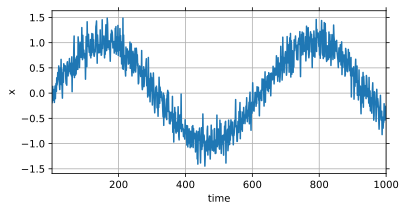

In [2]:
T = 1000
time = torch.arange(1, T+1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

我们要做的事情就是给定过去的数据，预测未来的数据值：

首先我们需要将数据映射为数据对$y_{t}=x_{t}$和$\mathbf{x}_{t}=\left[x_{t-\tau}, \ldots, x_{t-1}\right]$

In [3]:
tau = 4
features = torch.zeros((T-tau), tau) # T-tau是样本数，tau是特征数。
features.shape

torch.Size([996, 4])

In [4]:
x.shape

torch.Size([1000])

In [5]:
for i in range(tau):
    features[:, i] = x[i: T-tau+i]  # 对每一列进行数据填充
    print(features[:, i].shape)

torch.Size([996])
torch.Size([996])
torch.Size([996])
torch.Size([996])


In [6]:
labels = x[tau:].reshape((-1, 1)) # 设置标签
labels.shape

torch.Size([996, 1])

In [7]:
batch_size, n_train = 16, 600
# 只有前`n_train`个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

使用一个简单的结构：只是一个拥有两个全连接层的多层感知机

In [8]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

loss = nn.MSELoss()

训练模型

In [9]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1}, 'f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

In [10]:
net = get_net()
train(net, train_iter, loss, 10, 0.01)

epoch 1, loss: 0.072597
epoch 2, loss: 0.060852
epoch 3, loss: 0.058598
epoch 4, loss: 0.054943
epoch 5, loss: 0.054783
epoch 6, loss: 0.052956
epoch 7, loss: 0.052628
epoch 8, loss: 0.052185
epoch 9, loss: 0.052476
epoch 10, loss: 0.054769


模型预测下一个时间步

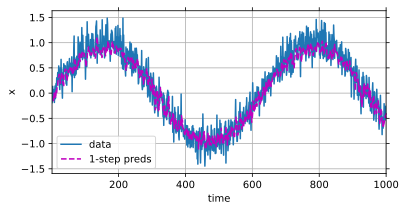

In [11]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]], [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

上述的这个问题是给定4个数据，预测下一个，稍微难一点的问题是，用预测出来的结果再往下预测。

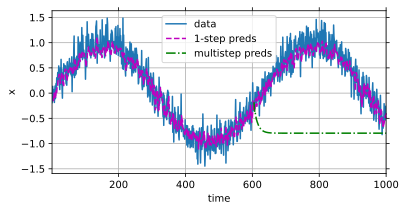

In [12]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T): # 从600个点往后预测。
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

基于$k=1,4,16,64$, 通过对整个序列预测的计算，我们可以更仔细地看下$k$步预测的困难。

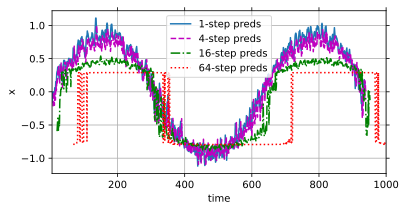

In [13]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列 `i` (`i` < `tau`) 是来自 `x` 的观测
# 其时间步从 `i + 1` 到 `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列 `i` (`i` >= `tau`) 是 (`i - tau + 1`)步的预测
# 其时间步从 `i + 1` 到 `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

## 问答


隐变量(hidden)一般是真实存在的东西，只不过我们没有观察到。但是潜变量(laten)包括了隐变量这一个假设，他可以是真实不存在的东西，你根本就观察不到。

1. 潜变量模型和隐马尔可夫模型有什么区别？

潜变量模型是可以使用隐马尔可夫假设的。

2. 